# Predicting Location via Indoor Positioning System 
## Data Preprocessing in Python 
This script and subsequent notebooks are the Python conversion of the Indoor Location case study from the book, 'Data Science in R' by Nolan and Lang. http://rdatasciencecases.org/code.html <BR>
* Team: Jonathan Tan, Lance Dacy, Reannan Mcdaniel, Shawn Jung 
* Last Update: 5/5/2020 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline  

In [2]:
# the raw text files are not in a csv format, and the first few lines are comments. Let's check if the comments exist in other parts as well. 
with open ('./data/offline.final.trace.txt',) as offline_file:
    comment_count = 0
    payload_count = 0 
    comment_str = [] 
    payload_str = []
    for line in offline_file:
        if line.startswith('#'):
            comment_count += 1
            comment_str.append(line)
        else:
            payload_count += 1
            payload_str.append(line)

print('the number of comment lines : %s' % comment_count)
print('the number of payload lines: %s' % payload_count)



the number of comment lines : 5312
the number of payload lines: 146080


In [3]:
# processing the raw data 
# it appears that each element can be separated by semicolons. And we see each key/value is defined with the 'equal' sign, and values such as position(pos) is seprated by commas 
payload_str[4]

't=1139643119538;id=00:02:2D:21:0F:33;pos=0.0,0.0,0.0;degree=0.0;00:14:bf:b1:97:8a=-46,2437000000,3;00:0f:a3:39:e1:c0=-55,2462000000,3;00:14:bf:b1:97:90=-57,2427000000,3;00:14:bf:3b:c7:c6=-67,2432000000,3;00:0f:a3:39:dd:cd=-66,2412000000,3;00:0f:a3:39:e0:4b=-80,2462000000,3;00:0f:a3:39:e2:10=-83,2437000000,3;00:14:bf:b1:97:81=-66,2422000000,3;02:00:42:55:31:00=-87,2457000000,1\n'

In [4]:
# I will define a function to process each line into tabular records consisted of raw time, scan MAC address, positions, orientation and signal data, similar to 'processLine' R function in the book. But I did not take this route as it took so long. Leaving the code here for furture reference. 

def process_line(payload_line):
    raw_time = payload_line.split(';')[0].split('=')[1]
    scan_mac = payload_line.split(';')[1].split('=')[1]
    pos_x, pos_y, pos_z = payload_line.split(';')[2].split('=')[1].split(',')
    orientation = payload_line.split(';')[3].split('=')[1]

    df1 = pd.DataFrame({'raw_time':[raw_time], 'scan_mac':[scan_mac], 'pos_x':[pos_x], 'pos_y':[pos_y], 'pos_z':[pos_z], 'orientation':[orientation]})

    scan_mac, mac, signal, channel, device_type = [], [], [], [], [] 

    for i in range(len(payload_line.split(';')[4:])):
        scan_mac.append(payload_line.split(';')[1].split('=')[1])
        mac.append(payload_line.split(';')[i+4].split('=')[0])
        signal.append(payload_line.split(';')[i+4].split('=')[1].split(',')[0])
        channel.append(payload_line.split(';')[i+4].split('=')[1].split(',')[1])
        device_type.append(payload_line.split(';')[i+4].split('=')[1].split(',')[2])

    df2 = pd.DataFrame({'scan_mac':scan_mac,'mac':mac, 'signal':signal, 'channel':channel, 'device_type':device_type})

    #df_line = df1.merge(df2)
    return df1, df2

In [5]:
# Let's check if the function works
#process_line(payload_str[4].rstrip())

In [6]:
# BTW, applying the function to all payload lines take long time. There can be a faster way in Python as they did with R, but I would rather try processing them with Pandas

#df_offline1 = pd.DataFrame()
#df_offline2 = pd.DataFrame()

#for line in payload_str:
#    df_temp1, df_temp2 = process_line(line.rstrip())

#    df_offline1 = df_offline1.append(df_temp1)
#    df_offline2 = df_offline2.append(df_temp2)
#df_offline = df_offline1.merge(df_offline2)    

Processing with Pandas

In [7]:
offline = pd.DataFrame(payload_str, columns=['original'])

In [8]:
# The raw data is in a kind of nested structure. So I will first take care of the position and time data per each obsevation 
offline = offline['original'].str.split(';',n=4, expand=True)
offline.head()

,0,1,2,3,4
0,t=1139643118358,id=00:02:2D:21:0F:33,"pos=0.0,0.0,0.0",degree=0.0,"00:14:bf:b1:97:8a=-38,2437000000,3;00:14:bf:b1..."
1,t=1139643118744,id=00:02:2D:21:0F:33,"pos=0.0,0.0,0.0",degree=0.0,"00:14:bf:b1:97:8a=-38,2437000000,3;00:0f:a3:39..."
2,t=1139643119002,id=00:02:2D:21:0F:33,"pos=0.0,0.0,0.0",degree=0.0,"00:14:bf:b1:97:8a=-38,2437000000,3;00:0f:a3:39..."
3,t=1139643119263,id=00:02:2D:21:0F:33,"pos=0.0,0.0,0.0",degree=0.0,"00:14:bf:b1:97:8a=-38,2437000000,3;00:14:bf:b1..."
4,t=1139643119538,id=00:02:2D:21:0F:33,"pos=0.0,0.0,0.0",degree=0.0,"00:14:bf:b1:97:8a=-46,2437000000,3;00:0f:a3:39..."


In [9]:
# Handling time data
offline['raw_time'] = pd.to_datetime(pd.to_numeric(offline[0].str.replace('t=','')), unit='ms')
offline = offline.drop(0, axis=1)

In [10]:
# the scan MAC address info 
offline['scan_mac']= offline[1].str.replace('id=','')
offline = offline.drop(1, axis=1)

In [11]:
# parsing the 3-D position and orientation 
offline[['pos_x', 'pos_y','pos_z']] = offline[2].str.replace('pos=','').str.split(',',n=3, expand=True)
offline['orientation'] = offline[3].str.replace('degree=','')
offline = offline.drop([2,3], axis=1)

In [12]:
offline[['pos_x', 'pos_y','pos_z', 'orientation']] = offline[['pos_x', 'pos_y','pos_z', 'orientation']].apply(pd.to_numeric, axis=1)

In [13]:
# stacking up the nested signal measurement as a separate df, 'off_signal'. This df will be joined to the original df
off_signal = offline[4].copy()
offline = offline.drop(4, axis=1)

off_signal = off_signal.str.split(';', expand=True).stack(dropna=True).reset_index(level=[0]).set_index('level_0')
off_signal[['mac','signal_raw']] = off_signal[0].str.split('=', expand=True)
off_signal[['signal', 'channel', 'device_type']] = off_signal['signal_raw'].str.split(',', expand=True)
off_signal['signal'] = off_signal['signal'].apply(pd.to_numeric)
off_signal = off_signal.drop([0,'signal_raw'], axis=1)

In [14]:
# finally, join the data frame 
offline = offline.join(off_signal)

In [15]:
offline.head()

,raw_time,scan_mac,pos_x,pos_y,pos_z,orientation,mac,signal,channel,device_type
0,2006-02-11 07:31:58.358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38.0,2437000000,3
0,2006-02-11 07:31:58.358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56.0,2427000000,3
0,2006-02-11 07:31:58.358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53.0,2462000000,3
0,2006-02-11 07:31:58.358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65.0,2442000000,3
0,2006-02-11 07:31:58.358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65.0,2422000000,3


In [16]:
# as explained in the book(p. 14), we can remove pos_z since we are interested in the 2-D-ish position indoor. And apply filtering on device-type (access point only) Refer to the Chapter 1 of the book for further information 
offline = offline[offline['device_type'] == '3']
offline = offline.drop(['scan_mac', 'pos_z'], axis=1)

In [17]:
offline.describe()

,pos_x,pos_y,orientation,signal
count,963604.000000,963604.000000,963604.000000,963604.000000
mean,13.545048,5.886030,167.172387,-61.500762
std,10.652896,2.740405,105.012372,12.071176
min,0.000000,0.000000,0.000000,-99.000000
25%,2.000000,3.000000,90.000000,-69.000000
50%,12.000000,6.000000,180.000000,-60.000000
75%,23.000000,8.000000,270.000000,-53.000000
max,33.000000,13.000000,359.900000,-25.000000


In [18]:
# Orientation data is supposed to have 8 unique values, but it seems that there are slight variation from the measurement. 
print(len(offline['orientation'].unique()))

203


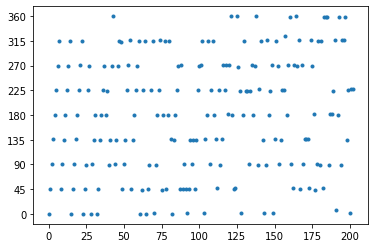

In [19]:
# The good news is, the orientation measurement remains within reasonable range of 45-degree split. We can round the value
plt.plot(offline['orientation'].unique(), marker='.', linestyle='none')
plt.yticks(np.linspace(0,360,9))
plt.show()

In [20]:
# define a function that rounds orientation value to nearest 8 slices(45 degree angle) 
def round_orientation(angle):
    refs = np.linspace(0,360,9)
    rounded_angle = refs[np.argmin(np.abs(angle - refs))]
    if rounded_angle==360:
        rounded_angle=0
    return rounded_angle

In [21]:
offline['orientation'] = offline['orientation'].apply(round_orientation)

In [22]:
# Let's save the dataframe as CSV for further analysis 
offline.to_csv('./data/offline_processed.csv', index=False)

We will prepare the online data(test data) with the same rules

In [23]:
with open ('./data/online.final.trace.txt',) as online_file:
    comment_count = 0
    payload_count = 0 
    comment_str = [] 
    payload_str = []
    for line in online_file:
        if line.startswith('#'):
            comment_count += 1
            comment_str.append(line)
        else:
            payload_count += 1
            payload_str.append(line)

print('the number of comment lines : %s' % comment_count)
print('the number of payload lines: %s' % payload_count)

the number of comment lines : 240
the number of payload lines: 6592


In [25]:
online = pd.DataFrame(payload_str, columns=['original'])
online = online['original'].str.split(';',n=4, expand=True)
online['raw_time'] = pd.to_datetime(pd.to_numeric(online[0].str.replace('t=','')), unit='ms')
online = online.drop(0, axis=1)
online['scan_mac']= online[1].str.replace('id=','')
online = online.drop(1, axis=1)
online[['pos_x', 'pos_y','pos_z']] = online[2].str.replace('pos=','').str.split(',',n=3, expand=True)
online['orientation'] = online[3].str.replace('degree=','')
online = online.drop([2,3], axis=1)
online[['pos_x', 'pos_y','pos_z', 'orientation']] = online[['pos_x', 'pos_y','pos_z', 'orientation']].apply(pd.to_numeric, axis=1)
on_signal = online[4].copy()
online = online.drop(4, axis=1)
on_signal = on_signal.str.split(';', expand=True).stack(dropna=True).reset_index(level=[0]).set_index('level_0')
on_signal[['mac','signal_raw']] = on_signal[0].str.split('=', expand=True)
on_signal[['signal', 'channel', 'device_type']] = on_signal['signal_raw'].str.split(',', expand=True)
on_signal['signal'] = on_signal['signal'].apply(pd.to_numeric)
on_signal = on_signal.drop([0,'signal_raw'], axis=1)
online = online.join(off_signal)
online = online[online['device_type'] == '3']
online = online.drop(['scan_mac', 'pos_z'], axis=1)


In [26]:
# define a function that rounds orientation value to nearest 8 slices(45 degree angle). Refer to EDA notebood to see why we are doing this. 
def round_orientation(angle):
    refs = np.linspace(0,360,9)
    rounded_angle = refs[np.argmin(np.abs(angle - refs))]
    if rounded_angle==360:
        rounded_angle=0
    return rounded_angle

In [27]:
online['orientation'] = online['orientation'].apply(round_orientation)

In [28]:
# it seems that online data also includes data from other APs. We will exclude such cases. Refer to EDA notebook. 
online['mac'].value_counts()

00:0f:a3:39:e1:c0    6590
00:0f:a3:39:dd:cd    6393
00:14:bf:b1:97:8a    6010
00:14:bf:3b:c7:c6    5833
00:14:bf:b1:97:90    5761
00:0f:a3:39:e0:4b    5401
00:14:bf:b1:97:81    5253
00:14:bf:b1:97:8d    5229
00:0f:a3:39:e2:10    5113
00:04:0e:5c:23:fc     275
00:30:bd:f8:7f:c5     195
Name: mac, dtype: int64

In [30]:
# Commenting this out, as we will process online data further in '03-knn stage'
legit_ap = offline['mac'].value_counts().index[0:7]
online = online[online['mac'].isin(legit_ap)]

In [31]:
online.head()

,raw_time,pos_x,pos_y,orientation,mac,signal,channel,device_type
0,2006-02-11 21:14:37.303,0.0,0.05,135.0,00:14:bf:b1:97:8a,-38,2437000000,3
0,2006-02-11 21:14:37.303,0.0,0.05,135.0,00:14:bf:b1:97:90,-56,2427000000,3
0,2006-02-11 21:14:37.303,0.0,0.05,135.0,00:0f:a3:39:e1:c0,-53,2462000000,3
0,2006-02-11 21:14:37.303,0.0,0.05,135.0,00:14:bf:b1:97:8d,-65,2442000000,3
0,2006-02-11 21:14:37.303,0.0,0.05,135.0,00:14:bf:b1:97:81,-65,2422000000,3


In [32]:
online.shape

(41069, 8)

In [33]:
# Let's save the dataframe as CSV without further pivoting. We will save a separate, pivot file for prediction.
online.to_csv('./data/online_processed.csv', index=False)

In [34]:
online['pos_xy'] = online[['pos_x', 'pos_y']].astype(str).agg('-'.join, axis=1)

In [36]:
online_pivot = pd.pivot_table(online, values='signal', index=['pos_xy', 'orientation'], columns='mac', aggfunc=np.mean).reset_index()

In [42]:
online_pivot = online_pivot[['pos_xy', '00:0f:a3:39:e1:c0', '00:0f:a3:39:dd:cd', '00:14:bf:b1:97:8a',
       '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:90',
       '00:14:bf:b1:97:81', 'orientation']]

In [43]:
online_pivot.to_csv('./data/online_pivot.csv', index=False)